# Titanic — Data Preprocessing Notebook

Mục tiêu: chuẩn hoá dữ liệu, xử lý missing, tạo feature, mã hoá, chuẩn hoá số và lưu dataset đã xử lý.

In [25]:
# 0. Thiết lập môi trường
import os, random
import numpy as np, pandas as pd
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Thư mục lưu kết quả (chạy lần đầu nếu cần)
os.makedirs('processed', exist_ok=True)
os.makedirs('pic', exist_ok=True)

# Path tới dữ liệu - chỉnh nếu cần
DATA_PATH = 'train.csv'  # nếu file ở nơi khác, chỉnh lại đường dẫn

## 1) Load dữ liệu và kiểm tra nhanh

In [26]:
# 1. Load dữ liệu
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2) Kiểm tra missing và thống kê cơ bản

In [27]:
# 2. Missing & dtypes & basic stats
print('Missing values per column:\n', df.isna().sum())
print('\nDtypes:\n', df.dtypes)
display(df.describe(include='all').T)

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dtypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


## 3) Chiến lược xử lý missing & feature engineering

- Nhóm “Age” theo (Pclass + Title) để tính median hợp lý.
- Chuyển “Name” → trích tiêu đề như Mr, Mrs, Miss, Master…
- Từ “SibSp, Parch” → tạo “FamilySize” và “IsAlone”.
- Từ “Fare” → tạo nhóm phân vị (FareBand).
- Từ “Cabin” → tạo biến nhị phân HasCabin và chữ cái CabinLetter.
- Từ “Ticket” → trích prefix (vì prefix có thể thể hiện nhóm xã hội).

In [28]:
# 3. Preprocessing & feature engineering (thực thi được)
df2 = df.copy()

# Embarked
df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])

# Fare
if df2['Fare'].isna().sum() > 0:
    df2['Fare'] = df2.groupby('Pclass')['Fare'].apply(lambda x: x.fillna(x.median()))

# Cabin features
df2['HasCabin'] = df2['Cabin'].notna().astype(int)
df2['CabinLetter'] = df2['Cabin'].fillna('X').map(lambda x: str(x)[0])

# Title extraction
def extract_title(name):
    if pd.isna(name): return 'Unknown'
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Mr','Mrs','Miss','Master']:
        return title
    return 'Rare'

df2['Title'] = df2['Name'].apply(extract_title)

# Family features
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2['IsAlone'] = (df2['FamilySize'] == 1).astype(int)

# Age imputation by Pclass + Title median
age_median = df2.groupby(['Pclass','Title'])['Age'].median()

def fill_age(row):
    if pd.isna(row['Age']):
        med = age_median.get((row['Pclass'], row['Title']), np.nan)
        if pd.isna(med):
            return df2['Age'].median()
        return med
    else:
        return row['Age']

df2['Age'] = df2.apply(fill_age, axis=1)

# Age bin and FareBand
df2['AgeBin'] = pd.cut(df2['Age'], bins=[0,12,20,40,60,120], labels=['Child','Teen','Adult','MidAge','Senior'])
df2['Fare'] = df2['Fare'].fillna(df2['Fare'].median())
df2['FareBand'] = pd.qcut(df2['Fare'], 4, labels=False)

# Ticket prefix
def ticket_prefix(t):
    t = str(t)
    parts = [p for p in t.replace('.', '').replace('/', '').split() if not p.isdigit()]
    if len(parts) == 0:
        return 'NONE'
    return parts[0]

df2['TicketPrefix'] = df2['Ticket'].apply(ticket_prefix)

# Show sample
display(df2.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,CabinLetter,Title,FamilySize,IsAlone,AgeBin,FareBand,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,X,Mr,2,0,Adult,0,A5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs,2,0,Adult,3,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,X,Miss,1,1,Adult,1,STONO2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs,2,0,Adult,3,NONE
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,X,Mr,1,1,Adult,1,NONE


## 4) Mã hoá categorical và lưu dataset đã xử lý

In [29]:
# 4. Select & encode features
df_final = df2.copy()

keep_cols = [
    'PassengerId','Survived','Pclass','Sex','Age','Fare',
    'Embarked','HasCabin','CabinLetter','Title','FamilySize','IsAlone',
    'AgeBin','FareBand','TicketPrefix'
]

df_final = df_final[keep_cols].copy()

# One-hot encode
to_onehot = ['Embarked','Title','CabinLetter','TicketPrefix','AgeBin']
df_final = pd.get_dummies(df_final, columns=to_onehot, drop_first=True)

# Sex to binary
df_final['Sex'] = df_final['Sex'].map({'male':1,'female':0}).astype(int)

# Check missing
print('Any nulls left:', df_final.isna().sum().sum())

# Save processed (unscaled)
os.makedirs('processed', exist_ok=True)
df_final.to_csv('processed/titanic_train_preprocessed.csv', index=False)
print('Saved processed/titanic_train_preprocessed.csv')

Any nulls left: 0
Saved processed/titanic_train_preprocessed.csv


## 5) Chuẩn hoá số liệu (Scaling) & lưu scaler

In [30]:
# 5. Scaling numeric features
from sklearn.preprocessing import StandardScaler
import joblib

num_cols = ['Age','Fare','FamilySize']
scaler = StandardScaler()
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

joblib.dump(scaler, 'processed/standard_scaler_titanic.pkl')
df_final.to_csv('processed/titanic_train_preprocessed_scaled.csv', index=False)
print('Saved scaled processed data and scaler')

Saved scaled processed data and scaler


## 6) Train/Validation split (lưu file)

In [31]:
# 6. Train/validation split
from sklearn.model_selection import train_test_split
X = df_final.drop(columns=['PassengerId','Survived'])
y = df_final['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train.to_csv('processed/X_train.csv', index=False)
X_val.to_csv('processed/X_val.csv', index=False)
y_train.to_csv('processed/y_train.csv', index=False)
y_val.to_csv('processed/y_val.csv', index=False)
print('Saved train/val splits to processed/')

Saved train/val splits to processed/


## 7) Kiểm tra & visualization mẫu

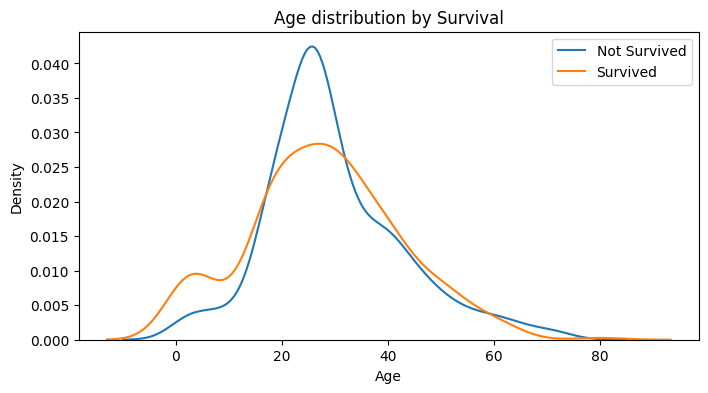

In [32]:
# Quick visual checks (saves into pic/)
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,4))
sns.kdeplot(df2[df2['Survived']==0]['Age'], label='Not Survived')
sns.kdeplot(df2[df2['Survived']==1]['Age'], label='Survived')
plt.title('Age distribution by Survival')
plt.legend()
plt.savefig('pic/titanic_age_dist.png', bbox_inches='tight', dpi=200)
plt.show()